*Task 2: Lookalike Model*

In [17]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')
customer_summary = transactions.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    avg_order_value=('TotalValue', 'mean'),
    total_quantity=('Quantity', 'sum'),
    num_transactions=('TransactionID', 'count')
).reset_index()

transactions_with_products = transactions.merge(products, on='ProductID', how='left')
product_summary = transactions_with_products.groupby('CustomerID').agg(
    unique_categories=('Category', lambda x: x.nunique()),
    most_purchased_category=('Category', lambda x: x.mode()[0] if not x.mode().empty else 'None')
).reset_index()

customer_profile = customers.merge(customer_summary, on='CustomerID', how='left').merge(
    product_summary, on='CustomerID', how='left'
).fillna(0)

features = ['total_spend', 'avg_order_value', 'total_quantity', 'num_transactions', 'unique_categories']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile[features])
similarity_matrix = cosine_similarity(scaled_features)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profile['CustomerID'], columns=customer_profile['CustomerID'])
lookalike_results = {}

for customer_id in customer_profile['CustomerID'][:20]:  # For first 20 customers (C0001 - C0020)
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]  # Top 3 lookalikes (excluding the customer themselves)
    lookalike_results[customer_id] = [
        (similar_cust, round(score, 4))  # List of tuples (similar customer ID, similarity score)
        for similar_cust, score in zip(similar_customers.index, similar_customers.values)
    ]
def recommend_lookalikes(customer_id):
    # Get similarity scores for the input customer
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]  # Get top 3 similar customers
    lookalikes = [
        {'SimilarCustomerID': similar_cust, 'SimilarityScore': round(score, 4)}
        for similar_cust, score in zip(similar_customers.index, similar_customers.values)
    ]
    return lookalikes
customer_id = 'C0001'
lookalikes = recommend_lookalikes(customer_id)
print(f"Top 3 lookalikes for Customer {customer_id}:")
for lookalike in lookalikes:
    print(f"Customer ID: {lookalike['SimilarCustomerID']}, Similarity Score: {lookalike['SimilarityScore']}")
lookalike_df = pd.DataFrame([
    {'CustomerID': cust, 'Lookalikes': str(lookalikes)}  # Convert list of tuples to string format
    for cust, lookalikes in lookalike_results.items()
])
lookalike_df.to_csv('SREYA_MONDAL_Lookalike.csv', index=False)
print("Sample Lookalike Recommendations:")
print(lookalike_df.head())

Top 3 lookalikes for Customer C0001:
Customer ID: C0164, Similarity Score: 0.9709
Customer ID: C0189, Similarity Score: 0.9281
Customer ID: C0118, Similarity Score: 0.8991
Sample Lookalike Recommendations:
  CustomerID                                         Lookalikes
0      C0001  [('C0164', np.float64(0.9709)), ('C0189', np.f...
1      C0002  [('C0199', np.float64(0.9919)), ('C0010', np.f...
2      C0003  [('C0027', np.float64(0.8539)), ('C0166', np.f...
3      C0004  [('C0165', np.float64(0.9899)), ('C0156', np.f...
4      C0005  [('C0131', np.float64(0.9972)), ('C0159', np.f...


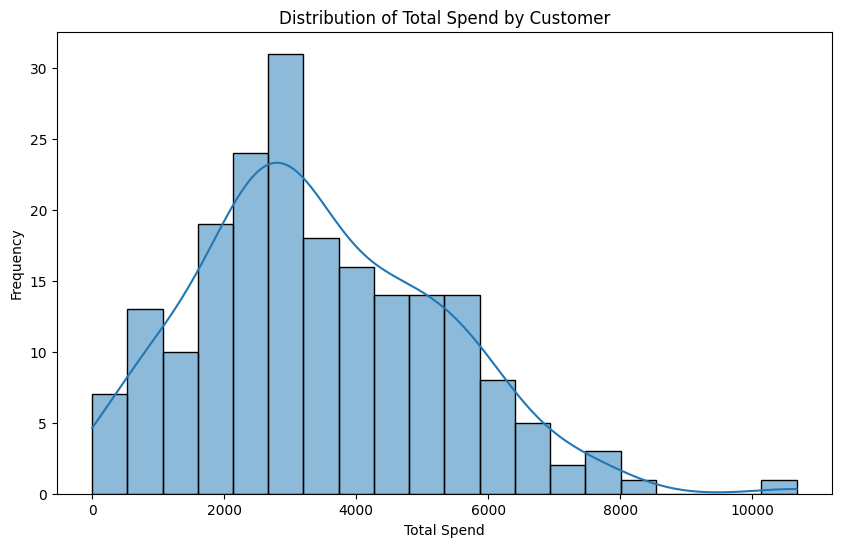

In [19]:
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)
customer_profile['total_spend'] = customer_profile['total_spend'].replace([float('inf'), -float('inf')], float('nan'))
plt.figure(figsize=(10, 6))
sns.histplot(customer_profile['total_spend'], kde=True, bins=20)
plt.title("Distribution of Total Spend by Customer")
plt.xlabel("Total Spend")
plt.ylabel("Frequency")
plt.show()